In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle
!cp kaggle(1).json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle(1).json

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `cp kaggle(1).json ~/.kaggle/'
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `chmod 600 /root/.kaggle/kaggle(1).json'


In [3]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 61% 37.0M/60.3M [00:00<00:00, 91.5MB/s]
100% 60.3M/60.3M [00:00<00:00, 125MB/s] 


In [4]:
!unzip "/content/fer2013.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [5]:
train_directory = "/content/train"
val_directory = "/content/test"
CLASS_NAMES = ['angry','disgust','fear','happy','neutral','sad','surprise']
CONFIGURATION = {
    "BATCH_SIZE":16,
    "IM_SIZE":48,
    "LEARNING_RATE":0.001,
    "N_EPOCHS":50,
    "DROPOUT_RATE":0.1,
    "REGULARIZATION_RATE":0.0,
    "N_FILTERS":6,
    "KERNEL_SIZE":3,
    "N_STRIDES":1,
    "POOL_SIZE":2,
    "N_DENSE_1":150,
    "N_DENSE_2":50,
    "NUM_CLASSES":7
}

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout,Layer,MaxPooling2D, GlobalAveragePooling2D, Add, Activation
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,        # Randomly shift the width of images by up to 10%
    height_shift_range = 0.1,       # Randomly shift the height of images by up to 10%
    horizontal_flip = True,         # Flip images horizontally at random
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)


In [8]:
train_generator = train_datagen.flow_from_directory(directory = train_directory,
                                                    target_size = (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = val_directory,
                                                              target_size = (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation")

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [9]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def VGGnet(input_shape=(48, 48, 1), num_classes=7):
    inputs = layers.Input(shape=input_shape)

    # CONV BLOCK 1
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv_2')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name='block1_pool')(x)
    x = layers.Dropout(0.25)(x)

    # CONV BLOCK 2
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name='block2_pool')(x)
    x = layers.Dropout(0.25)(x)

    # CONV BLOCK 3
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name='block3_pool')(x)
    x = layers.Dropout(0.25)(x)

    # CONV BLOCK 4
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name='block4_pool')(x)
    x = layers.Dropout(0.25)(x)

    # CONV BLOCK 5
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name='block5_pool')(x)
    x = layers.Dropout(0.25)(x)

    # FULLY CONNECTED LAYERS
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0005), name='fully_connected_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0005), name='fully_connected_2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)

    # OUTPUT LAYER
    outputs = layers.Dense(7, activation='softmax', name='output')(x)

    model = models.Model(inputs, outputs, name='VGGnet')
    return model

# Example usage:
model = VGGnet(input_shape=(48, 48, 1), num_classes=7)
model.summary()


Model: "VGGnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv_2 (Conv2D)               │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv_1 (Conv2D)               │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv_1 (Conv2D)               │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv_1 (Conv2D)               │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv_1 (Conv2D)               │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 3, 3, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 4,185,095 (15.96 MB)

 Trainable params: 4,180,615 (15.95 MB)

 Non-trainable params: 4,480 (17.50 KB)

In [11]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name='accuracy'),TopKCategoricalAccuracy(k=2,name='top_2_accuracy')]
for layer in model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath="best_model.h5",  # Save model as .h5 file
    monitor="val_accuracy",  # Monitor validation accuracy
    save_best_only=True,  # Save only the best model
    mode="max",  # Maximize val_accuracy
    verbose=1
)
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor validation loss
    factor=0.5,  # Reduce LR by 50% when needed
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-6,  # Minimum LR to avoid too slow training
    verbose=1  # Print when LR is reduced
)
history = model.fit(x = train_generator,epochs = 100,validation_data = validation_generator,callbacks=[checkpoint_callback,reduce_lr])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2419 - loss: 2.0149 - top_2_accuracy: 0.4101
Epoch 1: val_accuracy improved from -inf to 0.24721, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.2420 - loss: 2.0147 - top_2_accuracy: 0.4101 - val_accuracy: 0.2472 - val_loss: 1.8516 - val_top_2_accuracy: 0.4190 - learning_rate: 0.0010
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2484 - loss: 1.8385 - top_2_accuracy: 0.4292
Epoch 2: val_accuracy did not improve from 0.24721
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.2484 - loss: 1.8384 - top_2_accuracy: 0.4292 - val_accuracy: 0.2472 - val_loss: 1.8112 - val_top_2_accuracy: 0.4455 - learning_rate: 0.0010
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2520 - loss: 1.8022 - top_2_accuracy: 0.4389
Epoch 3: val_accuracy improved from 0.24721 to 0.26397, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.2520 - loss: 1.8021 - top_2_accuracy: 0.4390 - val_accuracy: 0.2640 - val_loss: 1.7897 - val_top_2_accuracy: 0.4602 - learning_rate: 0.0010
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2645 - loss: 1.7858 - top_2_accuracy: 0.4527
Epoch 4: val_accuracy improved from 0.26397 to 0.30307, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.2645 - loss: 1.7858 - top_2_accuracy: 0.4527 - val_accuracy: 0.3031 - val_loss: 1.7247 - val_top_2_accuracy: 0.5140 - learning_rate: 0.0010
Epoch 5/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3005 - loss: 1.7271 - top_2_accuracy: 0.4979
Epoch 5: val_accuracy improved from 0.30307 to 0.36802, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.3005 - loss: 1.7270 - top_2_accuracy: 0.4979 - val_accuracy: 0.3680 - val_loss: 1.5966 - val_top_2_accuracy: 0.5656 - learning_rate: 0.0010
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3384 - loss: 1.6535 - top_2_accuracy: 0.5350
Epoch 6: val_accuracy improved from 0.36802 to 0.42947, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.3384 - loss: 1.6534 - top_2_accuracy: 0.5350 - val_accuracy: 0.4295 - val_loss: 1.4805 - val_top_2_accuracy: 0.6138 - learning_rate: 0.0010
Epoch 7/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3835 - loss: 1.5705 - top_2_accuracy: 0.5794
Epoch 7: val_accuracy did not improve from 0.42947
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.3835 - loss: 1.5705 - top_2_accuracy: 0.5794 - val_accuracy: 0.4022 - val_loss: 1.5040 - val_top_2_accuracy: 0.5985 - learning_rate: 0.0010
Epoch 8/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4039 - loss: 1.5306 - top_2_accuracy: 0.6006
Epoch 8: val_accuracy improved from 0.42947 to 0.46508, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.4039 - loss: 1.5305 - top_2_accuracy: 0.6006 - val_accuracy: 0.4651 - val_loss: 1.3872 - val_top_2_accuracy: 0.6515 - learning_rate: 0.0010
Epoch 9/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4321 - loss: 1.4776 - top_2_accuracy: 0.6307
Epoch 9: val_accuracy improved from 0.46508 to 0.49092, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.4321 - loss: 1.4776 - top_2_accuracy: 0.6307 - val_accuracy: 0.4909 - val_loss: 1.3412 - val_top_2_accuracy: 0.6774 - learning_rate: 0.0010
Epoch 10/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4465 - loss: 1.4431 - top_2_accuracy: 0.6474
Epoch 10: val_accuracy improved from 0.49092 to 0.50628, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.4465 - loss: 1.4431 - top_2_accuracy: 0.6474 - val_accuracy: 0.5063 - val_loss: 1.3105 - val_top_2_accuracy: 0.6941 - learning_rate: 0.0010
Epoch 11/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4620 - loss: 1.3999 - top_2_accuracy: 0.6593
Epoch 11: val_accuracy improved from 0.50628 to 0.51187, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.4620 - loss: 1.3999 - top_2_accuracy: 0.6593 - val_accuracy: 0.5119 - val_loss: 1.2994 - val_top_2_accuracy: 0.7137 - learning_rate: 0.0010
Epoch 12/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4612 - loss: 1.4069 - top_2_accuracy: 0.6585
Epoch 12: val_accuracy improved from 0.51187 to 0.51327, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.4612 - loss: 1.4068 - top_2_accuracy: 0.6585 - val_accuracy: 0.5133 - val_loss: 1.2801 - val_top_2_accuracy: 0.7186 - learning_rate: 0.0010
Epoch 13/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4648 - loss: 1.4022 - top_2_accuracy: 0.6662
Epoch 13: val_accuracy improved from 0.51327 to 0.51606, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.4648 - loss: 1.4021 - top_2_accuracy: 0.6662 - val_accuracy: 0.5161 - val_loss: 1.2710 - val_top_2_accuracy: 0.7158 - learning_rate: 0.0010
Epoch 14/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4750 - loss: 1.3760 - top_2_accuracy: 0.6762
Epoch 14: val_accuracy improved from 0.51606 to 0.53422, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.4750 - loss: 1.3760 - top_2_accuracy: 0.6762 - val_accuracy: 0.5342 - val_loss: 1.2271 - val_top_2_accuracy: 0.7277 - learning_rate: 0.0010
Epoch 15/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4856 - loss: 1.3507 - top_2_accuracy: 0.6780
Epoch 15: val_accuracy did not improve from 0.53422
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.4855 - loss: 1.3507 - top_2_accuracy: 0.6780 - val_accuracy: 0.5203 - val_loss: 1.2544 - val_top_2_accuracy: 0.7242 - learning_rate: 0.0010
Epoch 16/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4806 - loss: 1.3633 - top_2_accuracy: 0.6780
Epoch 16: val_accuracy improved from 0.53422 to 0.54330, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.4806 - loss: 1.3633 - top_2_accuracy: 0.6780 - val_accuracy: 0.5433 - val_loss: 1.2127 - val_top_2_accuracy: 0.7270 - learning_rate: 0.0010
Epoch 17/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4909 - loss: 1.3443 - top_2_accuracy: 0.6940
Epoch 17: val_accuracy did not improve from 0.54330
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.4909 - loss: 1.3443 - top_2_accuracy: 0.6940 - val_accuracy: 0.5307 - val_loss: 1.2258 - val_top_2_accuracy: 0.7332 - learning_rate: 0.0010
Epoch 18/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4951 - loss: 1.3259 - top_2_accuracy: 0.6953
Epoch 18: val_accuracy did not improve from 0.54330
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.4951 - loss: 1.3259 - top_2_accuracy: 0.6953 - val_accuracy: 0.5391 - val_loss: 1.2205 - val_top_2_accuracy: 0.7451 - learning_rate: 0.0010
Epoch 19/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5048 - l

359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.5075 - loss: 1.3096 - top_2_accuracy: 0.7025 - val_accuracy: 0.5608 - val_loss: 1.1485 - val_top_2_accuracy: 0.7591 - learning_rate: 5.0000e-04
Epoch 21/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5130 - loss: 1.2814 - top_2_accuracy: 0.7118
Epoch 21: val_accuracy improved from 0.56075 to 0.56494, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.5130 - loss: 1.2814 - top_2_accuracy: 0.7118 - val_accuracy: 0.5649 - val_loss: 1.1478 - val_top_2_accuracy: 0.7619 - learning_rate: 5.0000e-04
Epoch 22/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5260 - loss: 1.2659 - top_2_accuracy: 0.7246
Epoch 22: val_accuracy did not improve from 0.56494
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.5260 - loss: 1.2659 - top_2_accuracy: 0.7246 - val_accuracy: 0.5649 - val_loss: 1.1441 - val_top_2_accuracy: 0.7709 - learning_rate: 5.0000e-04
Epoch 23/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5230 - loss: 1.2649 - top_2_accuracy: 0.7194
Epoch 23: val_accuracy improved from 0.56494 to 0.57961, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.5230 - loss: 1.2649 - top_2_accuracy: 0.7194 - val_accuracy: 0.5796 - val_loss: 1.1362 - val_top_2_accuracy: 0.7675 - learning_rate: 5.0000e-04
Epoch 24/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5309 - loss: 1.2564 - top_2_accuracy: 0.7205
Epoch 24: val_accuracy did not improve from 0.57961
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.5309 - loss: 1.2563 - top_2_accuracy: 0.7205 - val_accuracy: 0.5733 - val_loss: 1.1336 - val_top_2_accuracy: 0.7703 - learning_rate: 5.0000e-04
Epoch 25/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5298 - loss: 1.2538 - top_2_accuracy: 0.7265
Epoch 25: val_accuracy did not improve from 0.57961
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.5298 - loss: 1.2538 - top_2_accuracy: 0.7265 - val_accuracy: 0.5670 - val_loss: 1.1410 - val_top_2_accuracy: 0.7633 - learning_rate: 5.0000e-04
Epoch 26/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy

359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.5442 - loss: 1.2268 - top_2_accuracy: 0.7348 - val_accuracy: 0.5803 - val_loss: 1.1115 - val_top_2_accuracy: 0.7807 - learning_rate: 2.5000e-04
Epoch 29/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5460 - loss: 1.2060 - top_2_accuracy: 0.7419
Epoch 29: val_accuracy did not improve from 0.58031
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.5460 - loss: 1.2060 - top_2_accuracy: 0.7419 - val_accuracy: 0.5789 - val_loss: 1.1097 - val_top_2_accuracy: 0.7842 - learning_rate: 2.5000e-04
Epoch 30/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5467 - loss: 1.2136 - top_2_accuracy: 0.7352
Epoch 30: val_accuracy improved from 0.58031 to 0.59078, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.5467 - loss: 1.2136 - top_2_accuracy: 0.7352 - val_accuracy: 0.5908 - val_loss: 1.0976 - val_top_2_accuracy: 0.7793 - learning_rate: 2.5000e-04
Epoch 31/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5429 - loss: 1.2115 - top_2_accuracy: 0.7415
Epoch 31: val_accuracy did not improve from 0.59078
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.5429 - loss: 1.2115 - top_2_accuracy: 0.7415 - val_accuracy: 0.5908 - val_loss: 1.0978 - val_top_2_accuracy: 0.7814 - learning_rate: 2.5000e-04
Epoch 32/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5479 - loss: 1.1984 - top_2_accuracy: 0.7440
Epoch 32: val_accuracy improved from 0.59078 to 0.59497, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.5479 - loss: 1.1984 - top_2_accuracy: 0.7440 - val_accuracy: 0.5950 - val_loss: 1.0901 - val_top_2_accuracy: 0.7863 - learning_rate: 2.5000e-04
Epoch 33/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5455 - loss: 1.2062 - top_2_accuracy: 0.7459
Epoch 33: val_accuracy did not improve from 0.59497
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.5455 - loss: 1.2062 - top_2_accuracy: 0.7459 - val_accuracy: 0.5915 - val_loss: 1.0915 - val_top_2_accuracy: 0.7807 - learning_rate: 2.5000e-04
Epoch 34/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5402 - loss: 1.2249 - top_2_accuracy: 0.7355
Epoch 34: val_accuracy did not improve from 0.59497
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.5403 - loss: 1.2248 - top_2_accuracy: 0.7355 - val_accuracy: 0.5859 - val_loss: 1.0919 - val_top_2_accuracy: 0.7842 - learning_rate: 2.5000e-04
Epoch 35/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy

359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.5491 - loss: 1.2029 - top_2_accuracy: 0.7426 - val_accuracy: 0.6061 - val_loss: 1.0833 - val_top_2_accuracy: 0.7905 - learning_rate: 2.5000e-04
Epoch 36/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5544 - loss: 1.1875 - top_2_accuracy: 0.7485
Epoch 36: val_accuracy did not improve from 0.60615
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.5544 - loss: 1.1876 - top_2_accuracy: 0.7485 - val_accuracy: 0.5971 - val_loss: 1.0911 - val_top_2_accuracy: 0.7765 - learning_rate: 2.5000e-04
Epoch 37/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5486 - loss: 1.1955 - top_2_accuracy: 0.7454
Epoch 37: val_accuracy did not improve from 0.60615
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.5486 - loss: 1.1955 - top_2_accuracy: 0.7454 - val_accuracy: 0.5838 - val_loss: 1.0948 - val_top_2_accuracy: 0.7814 - learning_rate: 2.5000e-04
Epoch 38/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy

359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.5676 - loss: 1.1710 - top_2_accuracy: 0.7563 - val_accuracy: 0.6068 - val_loss: 1.0720 - val_top_2_accuracy: 0.7884 - learning_rate: 2.5000e-04
Epoch 40/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5605 - loss: 1.1764 - top_2_accuracy: 0.7543
Epoch 40: val_accuracy did not improve from 0.60684
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.5605 - loss: 1.1764 - top_2_accuracy: 0.7543 - val_accuracy: 0.5957 - val_loss: 1.0720 - val_top_2_accuracy: 0.7933 - learning_rate: 2.5000e-04
Epoch 41/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5525 - loss: 1.1833 - top_2_accuracy: 0.7536
Epoch 41: val_accuracy did not improve from 0.60684
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.5525 - loss: 1.1833 - top_2_accuracy: 0.7536 - val_accuracy: 0.6054 - val_loss: 1.0611 - val_top_2_accuracy: 0.7961 - learning_rate: 2.5000e-04
Epoch 42/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy

359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.5681 - loss: 1.1650 - top_2_accuracy: 0.7592 - val_accuracy: 0.6075 - val_loss: 1.0657 - val_top_2_accuracy: 0.8017 - learning_rate: 2.5000e-04
Epoch 45/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5603 - loss: 1.1762 - top_2_accuracy: 0.7509
Epoch 45: val_accuracy improved from 0.60754 to 0.60894, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.5603 - loss: 1.1762 - top_2_accuracy: 0.7509 - val_accuracy: 0.6089 - val_loss: 1.0554 - val_top_2_accuracy: 0.7975 - learning_rate: 2.5000e-04
Epoch 46/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5674 - loss: 1.1551 - top_2_accuracy: 0.7608
Epoch 46: val_accuracy improved from 0.60894 to 0.60964, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.5674 - loss: 1.1552 - top_2_accuracy: 0.7608 - val_accuracy: 0.6096 - val_loss: 1.0550 - val_top_2_accuracy: 0.7968 - learning_rate: 2.5000e-04
Epoch 47/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5703 - loss: 1.1567 - top_2_accuracy: 0.7544
Epoch 47: val_accuracy did not improve from 0.60964
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.5703 - loss: 1.1567 - top_2_accuracy: 0.7545 - val_accuracy: 0.6075 - val_loss: 1.0538 - val_top_2_accuracy: 0.7996 - learning_rate: 2.5000e-04
Epoch 48/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5636 - loss: 1.1672 - top_2_accuracy: 0.7560
Epoch 48: val_accuracy improved from 0.60964 to 0.61592, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.5636 - loss: 1.1672 - top_2_accuracy: 0.7560 - val_accuracy: 0.6159 - val_loss: 1.0468 - val_top_2_accuracy: 0.7870 - learning_rate: 2.5000e-04
Epoch 49/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5682 - loss: 1.1558 - top_2_accuracy: 0.7565
Epoch 49: val_accuracy did not improve from 0.61592
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.5682 - loss: 1.1558 - top_2_accuracy: 0.7565 - val_accuracy: 0.6013 - val_loss: 1.0572 - val_top_2_accuracy: 0.8010 - learning_rate: 2.5000e-04
Epoch 50/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5714 - loss: 1.1480 - top_2_accuracy: 0.7634
Epoch 50: val_accuracy did not improve from 0.61592
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.5714 - loss: 1.1480 - top_2_accuracy: 0.7634 - val_accuracy: 0.5999 - val_loss: 1.0520 - val_top_2_accuracy: 0.7961 - learning_rate: 2.5000e-04
Epoch 51/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy

359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.5698 - loss: 1.1503 - top_2_accuracy: 0.7639 - val_accuracy: 0.6215 - val_loss: 1.0435 - val_top_2_accuracy: 0.8031 - learning_rate: 2.5000e-04
Epoch 53/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5648 - loss: 1.1635 - top_2_accuracy: 0.7616
Epoch 53: val_accuracy did not improve from 0.62151
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.5648 - loss: 1.1635 - top_2_accuracy: 0.7616 - val_accuracy: 0.6166 - val_loss: 1.0474 - val_top_2_accuracy: 0.7996 - learning_rate: 2.5000e-04
Epoch 54/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5689 - loss: 1.1486 - top_2_accuracy: 0.7620
Epoch 54: val_accuracy did not improve from 0.62151
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.5689 - loss: 1.1486 - top_2_accuracy: 0.7620 - val_accuracy: 0.6208 - val_loss: 1.0324 - val_top_2_accuracy: 0.8010 - learning_rate: 2.5000e-04
Epoch 55/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy

359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.5879 - loss: 1.1087 - top_2_accuracy: 0.7742 - val_accuracy: 0.6243 - val_loss: 1.0246 - val_top_2_accuracy: 0.8122 - learning_rate: 6.2500e-05
Epoch 63/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5913 - loss: 1.1068 - top_2_accuracy: 0.7791
Epoch 63: val_accuracy did not improve from 0.62430
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.5913 - loss: 1.1068 - top_2_accuracy: 0.7791 - val_accuracy: 0.6243 - val_loss: 1.0223 - val_top_2_accuracy: 0.8080 - learning_rate: 6.2500e-05
Epoch 64/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5794 - loss: 1.1123 - top_2_accuracy: 0.7715
Epoch 64: val_accuracy did not improve from 0.62430
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.5794 - loss: 1.1123 - top_2_accuracy: 0.7715 - val_accuracy: 0.6208 - val_loss: 1.0263 - val_top_2_accuracy: 0.8094 - learning_rate: 6.2500e-05
Epoch 65/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy

359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.5868 - loss: 1.1047 - top_2_accuracy: 0.7769 - val_accuracy: 0.6250 - val_loss: 1.0199 - val_top_2_accuracy: 0.8142 - learning_rate: 1.5625e-05
Epoch 75/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5871 - loss: 1.1102 - top_2_accuracy: 0.7775
Epoch 75: val_accuracy did not improve from 0.62500

Epoch 75: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.5871 - loss: 1.1102 - top_2_accuracy: 0.7775 - val_accuracy: 0.6208 - val_loss: 1.0200 - val_top_2_accuracy: 0.8149 - learning_rate: 1.5625e-05
Epoch 76/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5914 - loss: 1.1041 - top_2_accuracy: 0.7791
Epoch 76: val_accuracy did not improve from 0.62500
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.5914 - loss: 1.1041 - top_2_accuracy: 0.7791 - val_accuracy: 0.6201 - val_loss: 1.0197 - val_top_2_accuracy: 0.8163 - learning_rate

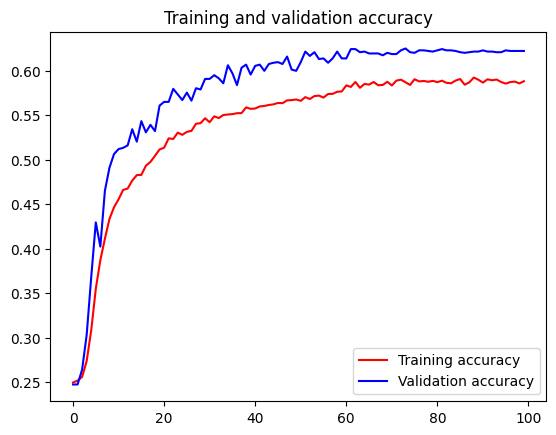

<Figure size 640x480 with 0 Axes>

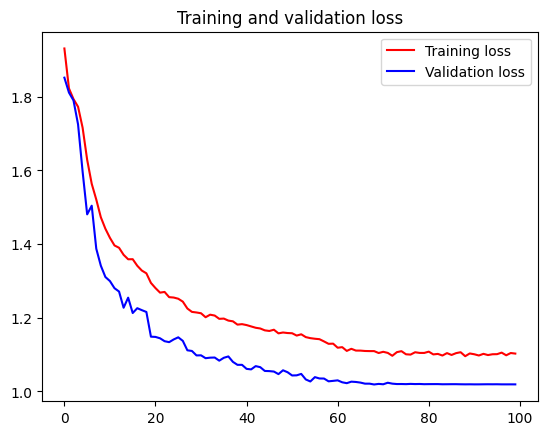

In [21]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [13]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
train_loss, train_acc,train_top2_acc = model.evaluate(train_generator)
test_loss, test_acc,test_top2_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6392 - loss: 0.9652 - top_2_accuracy: 0.8271
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6307 - loss: 1.0238 - top_2_accuracy: 0.8044
final train accuracy = 64.25 , validation accuracy = 62.22
